In [1]:
%load_ext autoreload
%autoreload 2

from datasets import load_dataset
from boolrank import *

dataset = load_dataset("data", split="train")

data = dataset.train_test_split(test_size=0.2, seed=42)
print(data)

model = DualSiglip2Model()

c:\Users\Simon\miniconda3\envs\RP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['q', 'd'],
        num_rows: 6100
    })
    test: Dataset({
        features: ['q', 'd'],
        num_rows: 1525
    })
})


You are using a model of type siglip_text_model to instantiate a model of type siglip2_text_model. This is not supported for all configurations of models and can yield errors.


In [2]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./siglip2/2",
    per_device_train_batch_size=2,
    num_train_epochs=1,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=100,
    save_steps=100,
    save_total_limit=2,
    remove_unused_columns=False,
    # max_steps=1000,
    bf16=True,
    optim="adamw_bnb_8bit",
    # torch_compile=True,
    # torch_compile_backend="inductor"
)

def collate_fn(batch):
    d = {
        "in_bool": [ex["q"] for ex in batch],
        "in_text": [ex["d"] for ex in batch],
    }
    return d

trainer = Trainer(
    model,
    training_args,
    train_dataset=data["train"],
    eval_dataset=data["test"],
    data_collator=collate_fn,
)

trainer.train(resume_from_checkpoint=False)

Step,Training Loss
100,1.317000
200,1.255200
300,1.256100
400,1.263500
500,1.246900
600,1.233200
700,1.222100
800,1.185300
900,1.223700
1000,1.202800


TrainOutput(global_step=3050, training_loss=1.1721528000128074, metrics={'train_runtime': 528.3813, 'train_samples_per_second': 11.545, 'train_steps_per_second': 5.772, 'total_flos': 0.0, 'train_loss': 1.1721528000128074, 'epoch': 1.0})

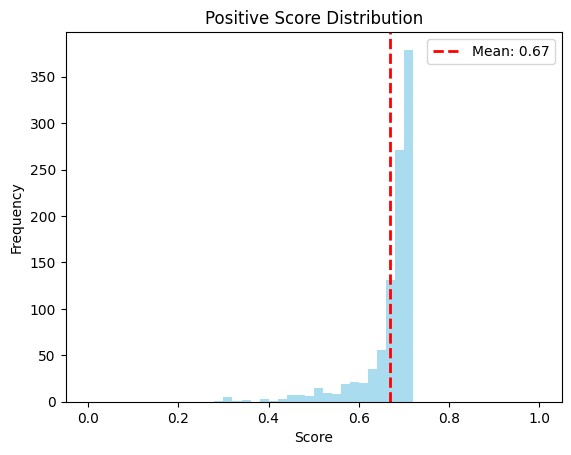

Positive mean: 0.6694 ± 0.0656


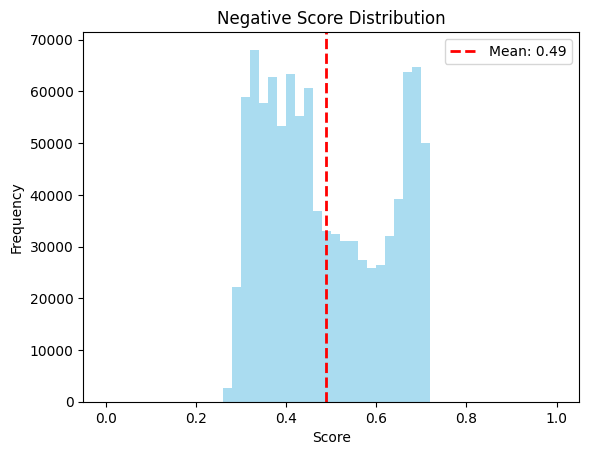

Negative mean: 0.4889 ± 0.1329


In [4]:
# model = model.load(r"./siglip2/2/checkpoint-3050/model.safetensors")
pos_scores = model.evaluate(data["test"]["q"][:1000], data["test"]["d"][:1000], plot=True)

In [ ]:
neg_data = RandomAccessMismatchedPairs(dataset, key_a="q", key_b="d").to_dataset(10, random_order=True)
model.evaluate(neg_data["q"], neg_data["d"])